# Imports

In [1]:
import os
import pickle
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime
from pathlib import Path

# Data loading

In [2]:
# Load the pickle file
train_data_path = pathlib.Path('data/train_data.pkl')
with open(train_data_path, 'rb') as f:
    data = pickle.load(f)

images = data['images']
labels = data['labels']

# Data visualization

In [3]:
images.shape, labels.shape

((1080, 28, 28, 3), (1080, 1))

In [4]:
image_ex = images[0]
label_ex = labels[0]
image_ex.shape, label_ex.shape

((28, 28, 3), (1,))

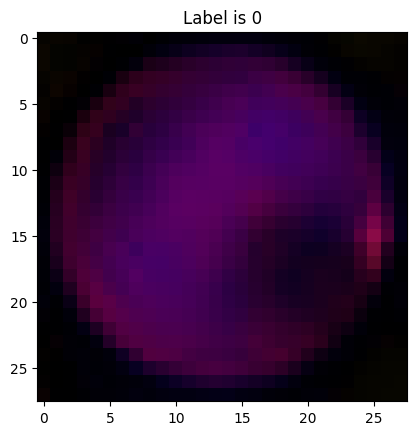

In [5]:
# Visualize first image
plt.title(f'Label is {label_ex.squeeze()}')
plt.imshow(image_ex)
plt.show()

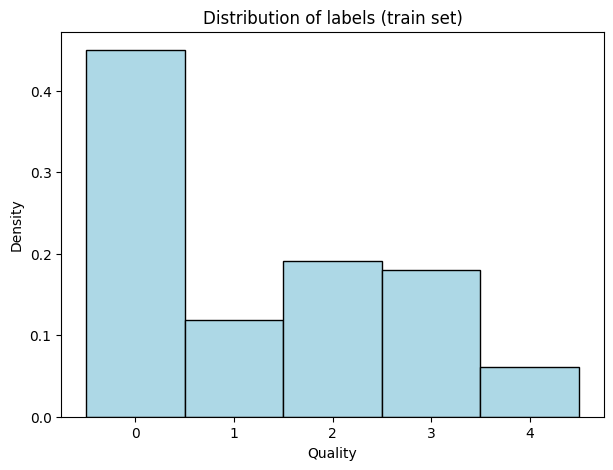

In [6]:
# Metrics
mean = np.mean(labels)
std = np.std(labels)
min_val = np.min(labels)
max_val = np.max(labels)

# Bin centering
bins = np.arange(min_val - 0.5, max_val + 1.5, 1) 

# Plot specifications
plt.figure(figsize=(7, 5))
plt.hist(labels, bins=bins, color='lightblue', edgecolor='black', density=True)
plt.title('Distribution of labels (train set)')
plt.xlabel('Quality')
plt.ylabel('Density')
plt.show()

# Kernel and One-VS-Rest SVM

In [7]:
def rbf_kernel_matrix(X1, X2, gamma=0.01):
    # With the identity ||x_1 - x_2||^2 = ||x_1||^2 + ||x_2||^2 - 2 * x_1 dot x_2
    X1_norm = (X1 ** 2).sum(axis=1).reshape(-1, 1)
    X2_norm = (X2 ** 2).sum(axis=1).reshape(-1, 1)
    dists = X1_norm + X2_norm.T - 2 * X1 @ X2.T
    dists = np.clip(dists, 0 , None)
    return np.exp(-gamma * dists)

In [8]:
class SVM:
    def __init__(self, w0, reg):
        self.w = np.array(w0, dtype=float)
        self.reg = reg
    
    def gradient(self, X, y):
        active = (1 - y * self.predict(X) > 0).astype(float)
        return - ((y * active)[:, np.newaxis] * X).mean(axis=0) + self.reg * self.w

    def train(self, images, labels, stepsize, n_steps):
        X = images
        y = labels
        losses = []
        errors = []

        for _ in range(n_steps):
            self.w -= stepsize * self.gradient(X, y)

            # Monitoring
            losses += [self.loss(X, y)]
            errors += [self.error_rate(X, y)]

        print("Training completed: the train error is {:.2f}%".format(errors[-1] * 100))
        # We will plot the loss later

    def predict(self, X):
        return np.dot(X, self.w)

    def loss(self, X, y):
        # Hinge loss
        y_hat = self.predict(X)
        return np.mean(np.maximum(0, 1 - y * y_hat)) + ((self.reg / 2) * (np.linalg.norm(self.w) ** 2))
    
    def error_rate(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y_hat * y < 0)

In [9]:
class MulticlassSVM:
    def __init__(self, n_classes, reg):
        self.n_classes = n_classes
        self.reg = reg
        self.classifiers = []
    
    def predict(self, X):
        """
        Prédire la classe avec le score le plus élevé
        """
        scores = np.zeros((X.shape[0], self.n_classes))
        
        for i, (_, svm) in enumerate(self.classifiers):
            scores[:, i] = svm.predict(X)
        
        # Retourner la classe avec le score maximum
        class_indices = np.argmax(scores, axis=1)
        return np.array([self.classifiers[i][0] for i in class_indices])
    
    def error_rate(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions != y.flatten())
    
    def train(self, X, y, stepsize, n_steps):
        """
        Entraîne un SVM pour chaque classe vs toutes les autres
        """
        unique_classes = np.unique(y)
        self.n_classes = len(unique_classes)
        
        for cls in unique_classes:
            print(f"Training classifier for class {cls}...")
            # Créer labels binaires : +1 pour cette classe, -1 pour les autres
            binary_labels = np.where(y == cls, 1, -1).flatten()
            
            # Entraîner un SVM binaire
            w0 = np.zeros(X.shape[1])
            svm = SVM(w0, self.reg)
            svm.train(X, binary_labels, stepsize, n_steps)
            self.classifiers.append((cls, svm))
    

# Training and validation

In [10]:
flatten_images = np.array([img.reshape(-1) for img in images])
flatten_images.shape

(1080, 2352)

In [11]:
normalized_images = flatten_images / 255.0

In [12]:
kernel = rbf_kernel_matrix(normalized_images, normalized_images, gamma=0.1)
kernel.shape

/var/folders/6q/5766hmx153z6858k28wrx7tc0000gn/T/ipykernel_2367/2116908537.py:5: RuntimeWarning: divide by zero encountered in matmul
  dists = X1_norm + X2_norm.T - 2 * X1 @ X2.T
/var/folders/6q/5766hmx153z6858k28wrx7tc0000gn/T/ipykernel_2367/2116908537.py:5: RuntimeWarning: overflow encountered in matmul
  dists = X1_norm + X2_norm.T - 2 * X1 @ X2.T
/var/folders/6q/5766hmx153z6858k28wrx7tc0000gn/T/ipykernel_2367/2116908537.py:5: RuntimeWarning: invalid value encountered in matmul
  dists = X1_norm + X2_norm.T - 2 * X1 @ X2.T


(1080, 1080)

In [13]:
N = labels.shape[0]
ratio = 0.8
train_idx = int(ratio * N)
val_idx = N - train_idx

print(f"Train samples: {train_idx}")
print(f"Val samples: {val_idx}")

kernel_train = kernel[:train_idx, :train_idx]  
kernel_val = kernel[train_idx:, :train_idx]     

labels_train = labels[:train_idx].flatten()
labels_val = labels[train_idx:].flatten()

print(f"\nKernel train shape: {kernel_train.shape}")
print(f"Kernel val shape: {kernel_val.shape}")
print(f"Labels train shape: {labels_train.shape}")
print(f"Labels val shape: {labels_val.shape}\n")

Train samples: 864
Val samples: 216

Kernel train shape: (864, 864)
Kernel val shape: (216, 864)
Labels train shape: (864,)
Labels val shape: (216,)



In [14]:
multi_svm = MulticlassSVM(n_classes=len(np.unique(labels)), reg=0.1)
multi_svm.train(kernel_train, labels_train, stepsize=0.01, n_steps=1000)

train_error = multi_svm.error_rate(kernel_train, labels_train)
val_error = multi_svm.error_rate(kernel_val, labels_val)

print(f"\n{'=' * 50}")
print(f"Train error: {(train_error * 100):.2f}%")
print(f"Val error: {(val_error * 100):.2f}%")
print(f"Gap (overfitting): {((val_error - train_error) * 100):.2f}%")
print('=' * 50)

Training classifier for class 0...
Training completed: the train error is 27.20%
Training classifier for class 1...
Training completed: the train error is 11.34%
Training classifier for class 2...
Training completed: the train error is 19.33%
Training classifier for class 3...
Training completed: the train error is 17.25%
Training classifier for class 4...
Training completed: the train error is 6.71%

Train error: 50.93%
Val error: 49.07%
Gap (overfitting): -1.85%


In [15]:
multi_svm.predict(kernel_val)

array([0, 3, 3, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 3, 0, 3, 0, 0, 0,
       3, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 2, 0, 0, 3, 2, 3, 0, 0, 0,
       0, 0, 3, 3, 2, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 2, 3, 1, 0, 3, 0, 2, 0, 0, 2, 2, 3,
       3, 0, 0, 2, 0, 0, 0, 0, 3, 0, 2, 2, 0, 0, 3, 0, 2, 0], dtype=uint8)

# Test on unseen data

In [16]:
# Load the pickle file
test_data_path = pathlib.Path('data/test_data.pkl')
with open(test_data_path, 'rb') as f:
    data = pickle.load(f)

images = data['images']

In [17]:
test_data = np.array([img.reshape(-1) for img in images]) / 255.0

In [18]:
test_kernel = rbf_kernel_matrix(test_data, normalized_images, gamma=0.1)

/var/folders/6q/5766hmx153z6858k28wrx7tc0000gn/T/ipykernel_2367/2116908537.py:5: RuntimeWarning: divide by zero encountered in matmul
  dists = X1_norm + X2_norm.T - 2 * X1 @ X2.T
/var/folders/6q/5766hmx153z6858k28wrx7tc0000gn/T/ipykernel_2367/2116908537.py:5: RuntimeWarning: overflow encountered in matmul
  dists = X1_norm + X2_norm.T - 2 * X1 @ X2.T
/var/folders/6q/5766hmx153z6858k28wrx7tc0000gn/T/ipykernel_2367/2116908537.py:5: RuntimeWarning: invalid value encountered in matmul
  dists = X1_norm + X2_norm.T - 2 * X1 @ X2.T


In [19]:
# We train again but on full data
multi_svm = MulticlassSVM(n_classes=len(np.unique(labels)), reg=0.01)
multi_svm.train(kernel, labels, stepsize=0.01, n_steps=500) 

test_predictions = multi_svm.predict(test_kernel)

Training classifier for class 0...
Training completed: the train error is 28.33%
Training classifier for class 1...
Training completed: the train error is 11.67%
Training classifier for class 2...
Training completed: the train error is 19.07%
Training classifier for class 3...
Training completed: the train error is 17.96%
Training classifier for class 4...
Training completed: the train error is 6.11%


In [20]:
test_predictions

array([0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 1, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0,
       3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 3, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0,
       0, 3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 3, 0, 0, 0,
       3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 2, 1, 0, 3, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 3, 0, 0, 0, 0, 1, 0, 0, 3,
       0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 2, 3,
       0, 1, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1,
       0, 0, 0, 0, 0, 3, 1, 3, 1, 0, 3, 1, 0, 0, 3, 0, 0, 0, 3, 0, 0, 1,
       3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 3, 2, 1, 3, 0, 0, 3, 0, 3, 0, 3, 0,

In [21]:
model_name = 'KernelSVM'
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"submission_{model_name}_{timestamp}.csv"

In [ ]:
path = 'output/'
if not os.path.isdir(path): os.mkdir(path)
fn_path = Path(os.path.join(path, filename))

In [23]:
data = {
    'ID': np.arange(1, len(test_predictions) + 1),
    'Label': test_predictions
}

output_df = pd.DataFrame(data)
output_df

,ID,Label
0,1,0
1,2,3
2,3,0
3,4,0
4,5,0
...,...,...
395,396,1
396,397,0
397,398,3
398,399,0


In [24]:
output_df.to_csv(fn_path, index=False)